# Creation of molecular embeddings for classifying compounds using Transformers

## Data Manipulation

First we get the latest version of the dataset from the repository.

In [2]:
import numpy as np
import pandas as pd
import requests
import io

url = 'https://github.com/GLambard/Molecules_Dataset_Collection/raw/master/originals/HIV.csv'

data = requests.get(url).content
df = pd.read_csv(io.StringIO(data.decode('utf-8')), index_col = 0)
df.reset_index(inplace=True)
df

,smiles,activity,HIV_active
0,CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...,CI,0
1,C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3...,CI,0
2,CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21,CI,0
3,Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1,CI,0
4,O=S(=O)(O)CCS(=O)(=O)O,CI,0
...,...,...,...
41122,CCC1CCC2c3c([nH]c4ccc(C)cc34)C3C(=O)N(N(C)C)C(...,CI,0
41123,Cc1ccc2[nH]c3c(c2c1)C1CCC(C(C)(C)C)CC1C1C(=O)N...,CI,0
41124,Cc1ccc(N2C(=O)C3c4[nH]c5ccccc5c4C4CCC(C(C)(C)C...,CI,0
41125,Cc1cccc(N2C(=O)C3c4[nH]c5ccccc5c4C4CCC(C(C)(C)...,CI,0


We create a vocabulary of tokens based on the SMILES specifications.

In [3]:
elements = 'H,He,Li,Be,B,C,N,O,F,Ne,Na,Mg,Al,Si,P,S,Cl,Ar,K,Ca,Sc,Ti,V,Cr,Mn,Fe,Co,Ni,Cu,Zn,Ga,Ge,As,Se,Br,Kr,Rb,Sr,Y,Zr,Nb,Mo,Tc,Ru,Rh,Pd,Ag,Cd,In,Sn,Sb,Te,I,Xe,Cs,Ba,La,Ce,Pr,Nd,Pm,Sm,Eu,Gd,Tb,Dy,Ho,Er,Tm,Yb,Lu,Hf,Ta,W,Re,Os,Ir,Pt,Au,Hg,Tl,Pb,Bi,Po,At,Rn,Fr,Ra,Ac,Th,Pa,U,Np,Pu,Am,Cm,Bk,Cf,Es,Fm,Md,No,Lr,Rf,Db,Sg,Bh,Hs,Mt,Ds,Rg,Cn,Uut,Fl,Uup,Lv,Uus,Uuo'
aromatic_atoms = 'b,c,n,o,p,s,as,se,te'
symbols = '[,],(,),=,+,-,#,:,@,.,%'
isotopes = '0,1,2,3,4,5,6,7,8,9'

elements = str(elements).split(',')
aromatic_atoms = str(aromatic_atoms).split(',')
symbols = str(symbols).split(',')
isotopes = str(isotopes).split(',')

smiles_vocabulary = elements + aromatic_atoms + symbols + isotopes

We define a method to process a single SMILES by spliting it into an array of tokens that are part of the SMILES vocabulary that we defined early.

In [4]:
def process_smiles(smiles, vocabulary):
  tokens = []
  i = 0;
  found = False;
  while i < len(smiles):
    if len(smiles[i:]) >= 3:
      if smiles[i:i+3] in vocabulary:
        tokens.append(smiles[i:i+3])
        i += 3
        found = True
    if len(smiles[i:]) >= 2 and not found:
      if smiles[i:i+2] in vocabulary:
        tokens.append(smiles[i:i+2])
        i += 2
        found = True
    if len(smiles[i:]) >= 1 and not found:
      if smiles[i] in vocabulary:
        tokens.append(smiles[i])
        i += 1
        found = True
    if not found:
      print('Error in value', smiles[i])
      print(smiles)
      break
    found = False
  return tokens

We also define a method to process an array of SMILES into a list of processed SMILES and their respective lengths which corresponds to the number of tokens they contain.

In [5]:
def process_smiles_array(smiles_array):
  processed_list = list()
  lengths = list()
  for i in range(len(smiles_array)):
      processed_smiles = process_smiles(smiles_array[i], smiles_vocabulary)
      processed_list.append(' '.join(processed_smiles))
      lengths.append(len(processed_smiles))
  return processed_list, lengths

Then we process all SMILES and insert the processed SMILES and their respective lengths into the dataset.

In [6]:
processed_smiles, smiles_lengths = process_smiles_array(df['smiles'].values)

df['processed_smiles'] = processed_smiles
df['smiles_length'] = smiles_lengths
df

,smiles,activity,HIV_active,processed_smiles,smiles_length
0,CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...,CI,0,C C C 1 = [ O + ] [ Cu - 3 ] 2 ( [ O + ] = C (...,51
1,C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3...,CI,0,C ( = C c 1 c c c c c 1 ) C 1 = [ O + ] [ Cu -...,83
2,CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21,CI,0,C C ( = O ) N 1 c 2 c c c c c 2 Sc 2 c 1 c c c...,31
3,Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1,CI,0,N c 1 c c c ( C = C c 2 c c c ( N ) c c 2 S ( ...,47
4,O=S(=O)(O)CCS(=O)(=O)O,CI,0,O = S ( = O ) ( O ) C C S ( = O ) ( = O ) O,22
...,...,...,...,...,...
41122,CCC1CCC2c3c([nH]c4ccc(C)cc34)C3C(=O)N(N(C)C)C(...,CI,0,C C C 1 C C C 2 c 3 c ( [ n H ] c 4 c c c ( C ...,55
41123,Cc1ccc2[nH]c3c(c2c1)C1CCC(C(C)(C)C)CC1C1C(=O)N...,CI,0,C c 1 c c c 2 [ n H ] c 3 c ( c 2 c 1 ) C 1 C ...,71
41124,Cc1ccc(N2C(=O)C3c4[nH]c5ccccc5c4C4CCC(C(C)(C)C...,CI,0,C c 1 c c c ( N 2 C ( = O ) C 3 c 4 [ n H ] c ...,60
41125,Cc1cccc(N2C(=O)C3c4[nH]c5ccccc5c4C4CCC(C(C)(C)...,CI,0,C c 1 c c c c ( N 2 C ( = O ) C 3 c 4 [ n H ] ...,60


To analyse the length of the SMILES in the dataset we plot a histogram with the distribution of the lengths.

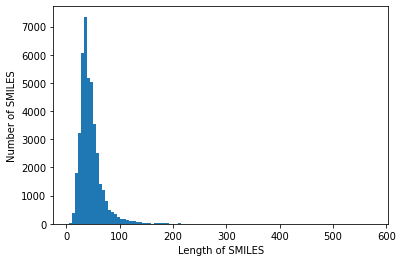

In [7]:
import matplotlib.pyplot as plt

plt.hist(smiles_lengths, bins=100)
plt.ylabel('Number of SMILES')
plt.xlabel('Length of SMILES')
plt.show()

Analysing the histogram, we can see that there are a few outliers that can cause us problems when feeding them to models. 

We define a range with minimum and maximum lengths for the SMILES and check to which percentage of our data it corresponds. 

In [8]:
length_range = (15, 125)

filtered = filter(lambda x: length_range[0] <= x <= length_range[1], smiles_lengths)
percentage = len(list(filtered)) / len(processed_smiles)
print('Percentage of instances with SMILES\' length between %s and %s: %s' % (length_range[0], length_range[1], percentage))

sequence_length = length_range[1]

Percentage of instances with SMILES' length between 15 and 125: 0.9813018211880273


Then we remove the instances that are not in the range we defined and correspond to the outliers.

In [9]:
df = df[(df['smiles_length'] >= length_range[0]) & (df['smiles_length'] <= length_range[1])]
df = df.drop('smiles_length', axis='columns')
df

,smiles,activity,HIV_active,processed_smiles
0,CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...,CI,0,C C C 1 = [ O + ] [ Cu - 3 ] 2 ( [ O + ] = C (...
1,C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3...,CI,0,C ( = C c 1 c c c c c 1 ) C 1 = [ O + ] [ Cu -...
2,CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21,CI,0,C C ( = O ) N 1 c 2 c c c c c 2 Sc 2 c 1 c c c...
3,Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1,CI,0,N c 1 c c c ( C = C c 2 c c c ( N ) c c 2 S ( ...
4,O=S(=O)(O)CCS(=O)(=O)O,CI,0,O = S ( = O ) ( O ) C C S ( = O ) ( = O ) O
...,...,...,...,...
41122,CCC1CCC2c3c([nH]c4ccc(C)cc34)C3C(=O)N(N(C)C)C(...,CI,0,C C C 1 C C C 2 c 3 c ( [ n H ] c 4 c c c ( C ...
41123,Cc1ccc2[nH]c3c(c2c1)C1CCC(C(C)(C)C)CC1C1C(=O)N...,CI,0,C c 1 c c c 2 [ n H ] c 3 c ( c 2 c 1 ) C 1 C ...
41124,Cc1ccc(N2C(=O)C3c4[nH]c5ccccc5c4C4CCC(C(C)(C)C...,CI,0,C c 1 c c c ( N 2 C ( = O ) C 3 c 4 [ n H ] c ...
41125,Cc1cccc(N2C(=O)C3c4[nH]c5ccccc5c4C4CCC(C(C)(C)...,CI,0,C c 1 c c c c ( N 2 C ( = O ) C 3 c 4 [ n H ] ...


## Transfer Learning: Feature extraction with BERT

### Introduction

BERT (Bidirectional Encoder Representations from Transformers), released in late 2018, is a language representation model pre-trained on a very large amount of unlabeled text corpus over different pre-training tasks.
It can be used for to extract high quality language features from our text data, or it can be fine-tuned on a specific task (for example, text classification) with our own data to produce state of the art predictions.

Since our goal is to extract features from the representation SMILES, we won't be fine-tuning the model.

This process typically follows one workflow like the following: 

- Instantiate a base model and load pre-trained weights into it.

- Run our dataset through it and record the output of one (or several) layers from the base model. This is called feature extraction.

- Use that output as input data for a new, smaller model.

### Setup

The package transformers from Hugging Face gives us a Tensorflow 2 interface for working with BERT.  

In [10]:
! pip install transformers

     |████████████████████████████████| 2.3MB 23.0MB/s 
     |████████████████████████████████| 901kB 43.5MB/s 
     |████████████████████████████████| 3.3MB 22.0MB/s 


We initialize the model and the tokenizer with BERT's cased version since the tokens in the SMILES vocabulary are case sensitive, for example, the token for the chemical element Carbon 'C' must be differentiated from the token for the aromatic element 'c'. 

In [11]:
import tensorflow as tf
from transformers import TFAutoModel, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

model = TFAutoModel.from_pretrained('bert-base-cased',            # use the 12-layer BERT model, with a case sensitive vocabulary
                                    output_attentions = False,    # whether the model returns attentions weights
                                    output_hidden_states = False) # whether the model returns all hidden-states

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


### Tokenization and Input Formatting

We define a method to handle the tokenization of a sequence of tokens (SMILES). This method returns two tensors, one with the indices of each token in BERT's vocabulary and another that corresponds to the attention mask which explicitly identifies tokens that are actually padding tokens.

In [12]:
def tokenize(sequence):
    encoding = tokenizer.encode_plus(sequence,                    # sequence to tokenize
                                     max_length=sequence_length,  # maximum length for the sequence
                                     truncation=True,             # truncate any sequence longer than the maximum length
                                     padding='max_length',        # allow any sequence shorter than the maximum length to be padded
                                     add_special_tokens=True,     # allow special tokens to indicate to BERT the beginning and the end of the sequence 
                                     return_attention_mask=True,  # indicate to output the attention mask
                                     return_token_type_ids=False, # indicate to not output the token type ids
                                     return_tensors='tf')         # return outputs as TensorFlow tensors
    return encoding

Here we have a simple demonstration of BERT's tokenization.

In [13]:
processed_smiles = df['processed_smiles'].values

smiles = processed_smiles[0]

encoding = tokenize(smiles)
input_ids = encoding['input_ids'][0].numpy()
attention_mask = encoding['attention_mask'][0].numpy()

print('Sequence of tokens:\n')
print(smiles)
print('\n')

print('Token indices:\n')
print(input_ids)
print('\n')

print('Attention mask:\n')
print(attention_mask)
print('\n')

print('Decoding of the indices:\n')
print(tokenizer.decode(input_ids))

Sequence of tokens:

C C C 1 = [ O + ] [ Cu - 3 ] 2 ( [ O + ] = C ( C C ) C 1 ) [ O + ] = C ( C C ) C C ( C C ) = [ O + ] 2


Token indices:

[ 101  140  140  140  122  134  164  152  116  166  164  140 1358  118
  124  166  123  113  164  152  116  166  134  140  113  140  140  114
  140  122  114  164  152  116  166  134  140  113  140  140  114  140
  140  113  140  140  114  134  164  152  116  166  123  102    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0]


Attention mask:

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

### Embeddings Extraction

BERT has 12 hidden states, each being the output of its 12 layers (transformer blocks). As it is the most common practice for extracting embeddings with BERT, we will only be using the last hidden state.
But, each token is represented by a vector with 768 features. This means that each sequence of tokens is represented by an array with the dimensions (length of the sequence, 768).
Since our goal is to generate a single one-dimensional vector as an embedding for each SMILES, our strategy is to average, for each token, the values of its vector. This means that each sequence of tokens is represented by an one-dimensional vector with 768 features.





In [14]:
def get_embedding(sequence):
  input_ids = tokenize(sequence)              # sequence tokenization
  outputs = model(input_ids)                  # run the sequence through BERT
  last_hidden_state = outputs[0]              # get the last hidden state
  vectors = last_hidden_state[0]              # get the token vectors from the last hidden state
  embedding = tf.reduce_mean(vectors, axis=0) # calculate the average for all token vectors
  return embedding.numpy()

Finally we extract the embeddings for each SMILES in our dataset.

In [15]:
from tqdm import tqdm

embeddings = []

#for smiles in tqdm(processed_smiles):
for i in range(10):
  embedding = get_embedding(smiles)
  embeddings.append(embedding)

In [16]:
embeddings

[array([ 4.74600464e-01,  3.33564997e-01,  9.61883068e-02,  5.60972802e-02,
         2.31562793e-01,  5.83217889e-02,  1.08460315e-01, -1.61507145e-01,
         1.66153595e-01, -2.49036789e-01, -7.24906251e-02,  4.45684552e-01,
        -1.19426074e-02,  3.65569800e-01, -6.80209935e-01, -4.57037777e-01,
         3.79819363e-01,  2.72261918e-01, -1.48406118e-01,  5.06703705e-02,
         1.26747163e-02, -3.09916377e-01,  2.39339486e-01,  2.12310985e-01,
         6.04500212e-02, -4.43352550e-01,  4.04573977e-01, -3.76667529e-02,
        -1.34405702e-01,  9.76057053e-01,  1.01463504e-01, -6.79479167e-02,
         1.82273701e-01,  1.43026933e-01,  1.55640438e-01, -6.50251135e-02,
         1.00683115e-01,  5.42165637e-01,  5.04038744e-02,  2.86492497e-01,
        -9.87508968e-02, -1.22330122e-01,  3.86188515e-02,  1.61643192e-01,
        -3.55552822e-01, -1.96197882e-01,  1.87526688e-01, -6.29778132e-02,
         2.78865814e-01,  1.58857945e-02,  2.89530545e-01, -3.73635560e-01,
         1.9

## References


1. Issa Annamoradnejad, Gohar Zoghi (2021). ColBERT: Using BERT Sentence Embedding for Humor Detection.

2. Na Pang1, Li Qian, Weimin Lyu, Jin-Dong Yang (2019). Transfer Learning for Scientific Data Chain Extraction in Small Chemical Corpus with joint BERT-CRF Model.

3. James Briggs (2020). TensorFlow and Transformers. Available at: https://towardsdatascience.com/tensorflow-and-transformers-df6fceaf57cc \[accessed 10 of May 2021\].

4. sameerpixelbot (2020). BERT Embeddings with TensorFlow 2.0. Available at: https://www.kaggle.com/sameerpixelbot/bert-embeddings-with-tensorflow-2-0-example \[accessed 10 of May 2021\].

5. Dharti Dhami (2020). Understanding BERT — Word Embeddings. Available at: https://medium.com/@dhartidhami/understanding-bert-word-embeddings-7dc4d2ea54ca \[accessed 10 of May 2021\].

6. Trishala Neeraj (2020). Feature-based Approach with BERT. Available at: https://trishalaneeraj.github.io/2020-04-04/feature-based-approach-with-bert \[accessed 10 of May 2021\].

7. fchollet (2020). Transfer learning & fine-tuning. Available at: https://keras.io/guides/transfer_learning/ \[accessed 10 of May 2021\].

8. Craig A. James (2016). OpenSMILES specification. Available at: http://opensmiles.org/opensmiles.html \[accessed 10 of May 2021\].
